In [3]:
%run PVModel_functions.ipynb

In [4]:
%run PVsystem_filterfunction_jack-may.ipynb

In [5]:
#This cell imports all the necessary packages & module data
import pandas as pd 
import numpy as np
from datetime import datetime
import datatools
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import pvlib
import pvanalytics
import math
import pvpltools
import seaborn as sns
import sklearn
from sklearn.metrics import r2_score
from pvpltools import iec61853
from pvpltools.module_efficiency import adr, heydenreich, motherpv, pvgis, mpm5, mpm6, bilinear
from pvpltools.module_efficiency import fit_efficiency_model, fit_bilinear

%matplotlib inline 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
#mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize']=22

In [6]:
#This is where all the input info should be
#Valid module names : LG, Panasonic, Can270, Can275, HanQPlus, HanQPeak, MissionSolar, Jinko
mod_name = 'Can275'
met_name =  'dbo.SNLA_MET_DataOut'

In [7]:
#Reads in an excel file of all necessary module coefficients, string lengths, system dates, etc
mod_info = pd.read_excel('module_coefficients.xlsx')
mod_info.index = mod_info['Manufacturer']
del mod_info['Manufacturer']
#defines the specific module given the previous user input and module coefficients file
module = mod_info[mod_name]
sys_name = module['table_name']
#start = '2020-10-01 00:00:00-07:00'
start = module['start']
#end = '2021-01-01 00:00:00-07:00'
end = module['end']

In [9]:
#Import sys & met databases & merge into one df
df = sys_met_data(mettablename=met_name, systablename=sys_name, start=start, end=end)

In [114]:
#Calculate Solar Data i.e. solar position, azimuth, zenith, etc.
sdf = calc_sol_data(time=df.index, latitude=module['latitude'], longitude=module['longitude'],tilt= module['tilt'],
                    pressure=df['Pressure_mBar_Avg'])

#Calculate Environmental Data i.e. airmass, pressure, POA irradiance compenents etc.
edf = calc_env_data(tilt=module['tilt'],altitude=module['altitude'], sur_azimuth=module['surface_azimuth'], 
                    sol_azimuth=sdf['azimuth'], zenith=sdf['apparent_zenith'], DNI=df['Direct_Wm2_Avg'], 
                    GHI=df['Global_Wm2_Avg'], DHI=df['Diffuse_Wm2_Avg'], DNI_extra=sdf['dni_extra'], model ='haydavies')

#Convert measured pressure to pascal's to use in absolute airmass function
pres = df['Pressure_mBar_Avg']*100

#Calculate airmass and add this to the Environmental Data
edf['am_abs'] = pvlib.atmosphere.get_absolute_airmass(airmass_relative=edf['airmass'], pressure=pres)

In [115]:
#Mask Solar Elevation below 15 deg and above 90 deg
sol_elev_mask = simple_filter(sys=sdf, variable='apparent_elevation', lower=15, upper=90, apply=False)
df = df.where(sol_elev_mask, np.nan)

In [118]:
#Calculate effective irradiance and cell temperature models using
sapm_data = sapm_param(POA_global=edf['poa_global'], POA_direct=edf['poa_direct'], POA_diffuse=edf['poa_diffuse'], 
                       amb_temp=df.Temp_C_Avg, ws_avg=df.WS_ms_Mean, am_abs=edf['am_abs'], aoi=edf['aoi'], module=module)
df = df.merge(sapm_data, how='inner', left_index=True, right_index=True)
df = df[~df.index.duplicated(keep='first')]

In [119]:
#Apply physical Filters on effective irradiance and cell temperature
df = simple_filter(sys=df, variable='eff_irr', lower=50, upper=1200, apply=True)
df = simple_filter(sys=df,variable='tcell', lower=-40, upper=85, apply=True)

**I've been thinking about switching the cell below this from reading in a certain pre-determined value into something that performs specific calculations for the system and sets bounds based on a percentage of data above/below the slope of current vs irradiance**

In [120]:
##### Filter out the data points with a certain ratio of current to irradiance
string_is ='str_1_i', 'str_2_i', 'str_3_i', 'str_4_i'
ratio_names = 'ratio str_1_i to eff_irr', 'ratio str_2_i to eff_irr', 'ratio str_3_i to eff_irr', 'ratio str_4_i to eff_irr'
#Calculate ratio from measured values
for string_i in string_is:
    df['ratio' + ' ' + string_i + ' ' 'to eff_irr'] = df[module[string_i]]/df['eff_irr'] 
#Apply filter on calculated values
for ratio_name in ratio_names:
    df = simple_filter(df, ratio_name, lower=module['ratio_lower'], upper=module['ratio_upper'], apply=True)

In [121]:
#Removing individual days that cause large errors due to shading, snow, etc

#filter out pole shading 
shade_list = ['Can270', 'HanQPlus']
if mod_name in shade_list:
    shade_start = '2020-10-06 00:00:00-07:00'
    shade_end = '2020-11-02 00:00:00-07:00'
    shask = (df.index > shade_start) & (df.index <= shade_end)
    df = df.loc[~shask]
    
#Filtering out days in 2019 that caused large outliers - could be due to snow on modules    
dec_list = ['Panasonic', 'LG']
if mod_name in dec_list:
    dec_start = '2019-12-29 00:00:00-07:00'
    dec_end = '2019-12-30 00:0:00-07:00'
    dec_mask = (df.index > dec_start) & (df.index <= dec_end)
    df = df.loc[~dec_mask]
#remove feb 23 2019
feb_start = '2019-02-23 00:00:00-07:00'
feb_end = '2019-02-24 10:00:00-07:00'
feb_mask = (df.index > feb_start) & (df.index <= feb_end)
df = df.loc[~feb_mask] 

#Removing Days in 2020 that had extremely large differences 
#remove sep 21 2020
sep_start = '2020-09-21 00:00:00-07:00'
sep_end = '2020-09-22 23:00:00-07:00'
sep_mask = (df.index > sep_start) & (df.index <= sep_end)
df = df.loc[~sep_mask]
#remove feb 5 2020
feb_start = '2020-02-05 00:00:00-07:00'
feb_end = '2020-02-05 23:00:00-07:00'
feb_mask = (df.index > feb_start) & (df.index <= feb_end)
df = df.loc[~feb_mask]

In [122]:
#Generate a results dataframe and add measured values
str_1 = meas_val(str_v=df[module['str_1_v']],str_i=df[module['str_1_i']])
str_2 = meas_val(str_v=df[module['str_2_v']],str_i=df[module['str_2_i']])
str_3 = meas_val(str_v=df[module['str_3_v']],str_i=df[module['str_3_i']])
str_4 = meas_val(str_v=df[module['str_4_v']],str_i=df[module['str_4_i']])

In [123]:
#Generate empty df to store appended results
newresults=[]

In [124]:
#Calcualte SAPM results and add to df
dc = sapm(eff_irr=df['eff_irr'], tcell=df['tcell'], module=module)
sapm_results = sapm_p(v_mp=dc['v_mp'], i_mp=dc['i_mp'], str_len=module['str_len']).to_frame()


sapm_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
sapm_results['Str_1'] = str_1
sapm_results['Str_2'] = str_2
sapm_results['Str_3'] = str_3
sapm_results['Str_4'] = str_4
sapm_results['Time'] = sapm_results.index
sapm_results['Year'] = sapm_results.index.year
sapm_results['Model Name'] = 'SAPM'
newresults.append(sapm_results)

In [125]:
#Calculate PVWatts results and add to df
pvw_results = (pvwatts(POA_eff = df['eff_irr'], cell_temp = df['tcell'], stc_mod_p = module['Power'], 
                Gpmp = module['Gpmp'],str_len = module['str_len'],temp_ref=25.0 )).to_frame()

pvw_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
pvw_results['Str_1'] = str_1
pvw_results['Str_2'] = str_2
pvw_results['Str_3'] = str_3
pvw_results['Str_4'] = str_4
pvw_results['Time'] = pvw_results.index
pvw_results['Year'] = pvw_results.index.year
pvw_results['Model Name'] = 'PVW'
newresults.append(pvw_results)

In [126]:
#Calculate CEC results and add to df

#Calculate parameters necessary to input into single diode model
cec_param = pvlib.pvsystem.calcparams_cec(effective_irradiance=df['eff_irr'], 
            temp_cell=df['tcell'], alpha_sc=module['alpha_sc'],a_ref=module['a_ref'], I_L_ref=module['I_L_ref'], 
            I_o_ref=module['I_o_ref'], R_sh_ref=module['R_sh_ref'],R_s=module['R_s'],Adjust=module['Adjust'])
#Calculate power using single diode model
cec_p = pvlib.pvsystem.singlediode(photocurrent = cec_param[0], saturation_current = cec_param[1], resistance_series =
                           cec_param[2], resistance_shunt = cec_param[3], nNsVth = cec_param[4], method = 'newton')
#Calculate string power
cec_results = sdm(p_mp=cec_p['p_mp'], str_len=module['str_len']).to_frame()


cec_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
cec_results['Str_1'] = str_1
cec_results['Str_2'] = str_2
cec_results['Str_3'] = str_3
cec_results['Str_4'] = str_4
cec_results['Time'] = cec_results.index
cec_results['Year'] = cec_results.index.year
cec_results['Model Name'] = 'CEC'
newresults.append(cec_results)

In [127]:
#Calculate Desoto results and add to df

#Calculate parameters necessary to input into single diode model
ds_param = pvlib.pvsystem.calcparams_desoto(effective_irradiance=df['eff_irr'], 
            temp_cell=df['tcell'], alpha_sc=module['alpha_sc'],a_ref=module['a_ref'], I_L_ref=module['I_L_ref'], 
            I_o_ref=module['I_o_ref'], R_sh_ref=module['R_sh_ref'],R_s=module['R_s'])
#Calculate power using single diode model
ds_p = pvlib.pvsystem.singlediode(photocurrent = ds_param[0], saturation_current = ds_param[1], resistance_series =
                           ds_param[2], resistance_shunt = ds_param[3], nNsVth = ds_param[4], method = 'newton')
#Calculate string power
des_results = sdm(p_mp=ds_p['p_mp'], str_len=module['str_len']).to_frame()

des_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
des_results['Str_1'] = str_1
des_results['Str_2'] = str_2
des_results['Str_3'] = str_3
des_results['Str_4'] = str_4
des_results['Time'] = des_results.index
des_results['Year'] = des_results.index.year
des_results['Model Name'] = 'DES'
newresults.append(des_results)

In [128]:
#Calculte PVSystem results and add to df

#Calculate parameters necessary to input into single diode model
pvs_param = pvlib.pvsystem.calcparams_pvsyst(effective_irradiance=df['eff_irr'],temp_cell=df['tcell'], 
            alpha_sc=module['alpha_sc'],gamma_ref=module['gamma_ref'],mu_gamma=module['mu_gamma'], 
            I_L_ref=module['I_L_ref'],I_o_ref=module['I_o_ref'],R_sh_ref=module['R_sh_ref'], R_sh_0=module['R_sh_0'],
            R_s=module['R_s'],cells_in_series=module['Cells_in_Series'])
#Calculate power using single diode model
pvs_p = pvlib.pvsystem.singlediode(photocurrent = pvs_param[0], saturation_current = pvs_param[1], resistance_series =
                           pvs_param[2], resistance_shunt = pvs_param[3], nNsVth = pvs_param[4], method = 'newton')
#Calculate string power
pvs_results = sdm(p_mp=pvs_p['p_mp'], str_len=module['str_len']).to_frame()

pvs_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
pvs_results['Str_1'] = str_1
pvs_results['Str_2'] = str_2
pvs_results['Str_3'] = str_3
pvs_results['Str_4'] = str_4
pvs_results['Time'] = pvs_results.index
pvs_results['Year'] = pvs_results.index.year
pvs_results['Model Name'] = 'PVS'
newresults.append(pvs_results)

In [129]:
#Import matrix of measurement data
measurements_file = 'Sandia_PV_Module_P-Matrix-and-TempCo-Data_2019.xlsx'
matrix = pd.read_excel(measurements_file, sheet_name = mod_name, usecols='B,C,H', header=None, skiprows=5, nrows=27)
matrix.columns = ['temperature', 'irradiance', 'p_mp']
# calculate efficiency from power
matrix = matrix.eval('eta = p_mp / irradiance')
eta_stc = matrix.query('irradiance == 1000 and temperature == 25').eta
matrix.eta /= eta_stc.values
# just keep the columns that are needed
matrix = matrix[['irradiance', 'temperature', 'eta']]

In [130]:
#Calculate ADR results and add to df
#Determine the parameters for the eff. model using non-linear least squares fit
popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=adr)
#Calculate eff. using adr model
adr_eff = adr(df['eff_irr'],df['tcell'],*popt)
#Calculate power given the above adr eff. 
adr_results = ((df['eff_irr']/1000) * (adr_eff) * (module['Power']) *12).to_frame()

adr_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
adr_results['Str_1'] = str_1
adr_results['Str_2'] = str_2
adr_results['Str_3'] = str_3
adr_results['Str_4'] = str_4
adr_results['Time'] = adr_results.index
adr_results['Year'] = adr_results.index.year
adr_results['Model Name'] = 'ADR'
newresults.append(adr_results)

In [131]:
popt

array([ 0.99925859, -7.80373189,  0.0325629 ,  0.05673333,  0.07688298])

In [132]:
#Calculate Heydenreich results and add to df
#Determine the parameters for the eff. model using non-linear least squares fit
popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance, temperature=matrix.temperature,
                                  eta=matrix.eta, model=heydenreich)
hey_eff = heydenreich(df['eff_irr'], df['tcell'], *popt)
hey_results = ((df['eff_irr']/1000) * (hey_eff) * (module['Power']) *12).to_frame()

hey_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
hey_results['Str_1'] = str_1
hey_results['Str_2'] = str_2
hey_results['Str_3'] = str_3
hey_results['Str_4'] = str_4
hey_results['Time'] = hey_results.index
hey_results['Year'] = hey_results.index.year
hey_results['Model Name'] = 'HEY'
newresults.append(hey_results)

In [133]:
popt

array([ 1.25838877e-04, -1.59083972e-01, -2.07426466e+00, -4.26720544e-03])

In [134]:
#Calculate MotherPV results and add to df
#Determine the parameters for the eff. model using non-linear least squares fit
popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=motherpv)
mother_eff = motherpv(df['eff_irr'], df['tcell'], *popt)
mot_results = ((df['eff_irr']/1000) * (mother_eff) * (module['Power']) * 12).to_frame()

mot_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
mot_results['Str_1'] = str_1
mot_results['Str_2'] = str_2
mot_results['Str_3'] = str_3
mot_results['Str_4'] = str_4
mot_results['Time'] = mot_results.index
mot_results['Year'] = mot_results.index.year
mot_results['Model Name'] = 'MOT'
newresults.append(mot_results)

In [135]:
popt

array([ 0.01830262, -0.02109253, -0.03803926, -0.0147248 , -0.00415662,
        0.08593418, -0.07782478])

In [136]:
#Calculate PVGIS results and add to df
#Determine the parameters for the eff. model using non-linear least squares fit
popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=pvgis)
pvgis_eff = pvgis(df['eff_irr'], df['tcell'], *popt)
pvg_results = ((df['eff_irr']/1000) * (pvgis_eff) * (module['Power']) *12).to_frame()

pvg_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
pvg_results['Str_1'] = str_1
pvg_results['Str_2'] = str_2
pvg_results['Str_3'] = str_3
pvg_results['Str_4'] = str_4
pvg_results['Time'] = pvg_results.index
pvg_results['Year'] = pvg_results.index.year
pvg_results['Model Name'] = 'PVG'
newresults.append(pvg_results)

In [137]:
popt

array([ 8.88321747e-03, -1.06931993e-02, -4.11674798e-03, -6.45339014e-06,
       -1.78160995e-05, -9.47669927e-07])

In [138]:
#Calculate MPM5 results and add to df
#Determine the parameters for the eff. model using non-linear least squares fit
popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=mpm5)
mpm5_eff = mpm5(df['eff_irr'], df['tcell'], *popt)
mpm5_results = ((df['eff_irr']/1000) * (mpm5_eff) * (module['Power']) *12).to_frame()

mpm5_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
mpm5_results['Str_1'] = str_1
mpm5_results['Str_2'] = str_2
mpm5_results['Str_3'] = str_3
mpm5_results['Str_4'] = str_4
mpm5_results['Time'] = mpm5_results.index
mpm5_results['Year'] = mpm5_results.index.year
mpm5_results['Model Name'] = 'MPM5'
newresults.append(mpm5_results)

In [139]:
popt

array([ 1.05689103, -0.00416998,  0.12859969, -0.05717796])

In [140]:
#Calculate MPM6 results and add to df
#Determine the parameters for the eff. model using non-linear least squares fit
popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=mpm6)
mpm6_eff = mpm6(df['eff_irr'], df['tcell'], *popt)
mpm6_results = ((df['eff_irr']/1000) * (mpm6_eff) * (module['Power']) *12).to_frame()

mpm6_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
mpm6_results['Str_1'] = str_1
mpm6_results['Str_2'] = str_2
mpm6_results['Str_3'] = str_3
mpm6_results['Str_4'] = str_4
mpm6_results['Time'] = mpm6_results.index
mpm6_results['Year'] = mpm6_results.index.year
mpm6_results['Model Name'] = 'MPM6'
newresults.append(mpm6_results)

In [141]:
popt

array([ 1.05132782e+00, -4.17043264e-03,  1.16130302e-01, -5.07731635e-02,
       -7.81487827e-04])

In [142]:
#Calculate Bilinear results and add to df
#Determine the parameters for the eff. model using non-linear least squares fit
interpolator = fit_bilinear(**matrix)
bilinear_eff = bilinear(df['eff_irr'], df['tcell'], interpolator)
bil_results = ((df['eff_irr']/1000) * (bilinear_eff) * (module['Power']) * 12).to_frame()

bil_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
bil_results['Str_1'] = str_1
bil_results['Str_2'] = str_2
bil_results['Str_3'] = str_3
bil_results['Str_4'] = str_4
bil_results['Time'] = bil_results.index
bil_results['Year'] = bil_results.index.year
bil_results['Model Name'] = 'BIL'
newresults.append(bil_results)

In [143]:
#Concat the results df and make the index a Datetime index
meta = pd.concat(newresults, ignore_index=True)
meta.index = meta['Time']

In [144]:
#Calculate MAPE and MBE 
strings = ['Str_1','Str_2','Str_3','Str_4']
for string in strings:
    meta['Diff ' + string] = (meta['Modeled Power'] - meta[string])
meta['MBE (W)'] = (meta['Diff Str_1'] + meta['Diff Str_2'] + meta['Diff Str_3'] + meta['Diff Str_4'])/4
for string in strings:
    meta['Abs%Diff ' + string] = 100* abs((meta['Modeled Power'] - meta[string])/(meta[string]))
meta['MAPE (%)'] = ((meta.iloc[:,[13,14,15,16]].mean(axis=1)))

In [145]:
meta

,Modeled Power,Str_1,Str_2,Str_3,Str_4,Time,Year,Model Name,Diff Str_1,Diff Str_2,Diff Str_3,Diff Str_4,MBE (W),Abs%Diff Str_1,Abs%Diff Str_2,Abs%Diff Str_3,Abs%Diff Str_4,MAPE (%)
Time,,,,,,,,,,,,,,,,,,
2018-01-30 00:00:00-07:00,NaN,NaN,NaN,NaN,NaN,2018-01-30 00:00:00-07:00,2018,SAPM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-30 00:01:00-07:00,NaN,NaN,NaN,NaN,NaN,2018-01-30 00:01:00-07:00,2018,SAPM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-30 00:02:00-07:00,NaN,NaN,NaN,NaN,NaN,2018-01-30 00:02:00-07:00,2018,SAPM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-30 00:03:00-07:00,NaN,NaN,NaN,NaN,NaN,2018-01-30 00:03:00-07:00,2018,SAPM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-30 00:04:00-07:00,NaN,NaN,NaN,NaN,NaN,2018-01-30 00:04:00-07:00,2018,SAPM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 23:56:00-07:00,NaN,NaN,NaN,NaN,NaN,2021-05-31 23:56:00-07:00,2021,BIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-31 23:57:00-07:00,NaN,NaN,NaN,NaN,NaN,2021-05-31 23:57:00-07:00,2021,BIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-31 23:58:00-07:00,NaN,NaN,NaN,NaN,NaN,2021-05-31 23:58:00-07:00,2021,BIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


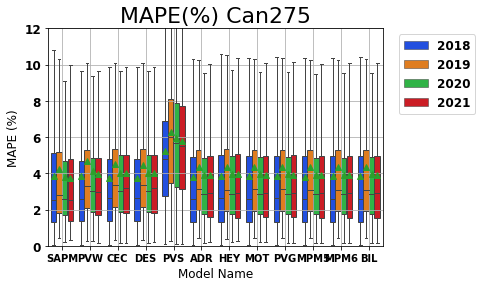

In [146]:
ax = sns.boxplot(x='Model Name', y='MAPE (%)', data = meta, hue='Year', showmeans=True, showfliers=False,palette='bright')
ax.grid(True)
ax.set_ylim([0,12])
ax.set_title('MAPE(%) '+mod_name)
ax.legend(bbox_to_anchor= (1.03, 1))

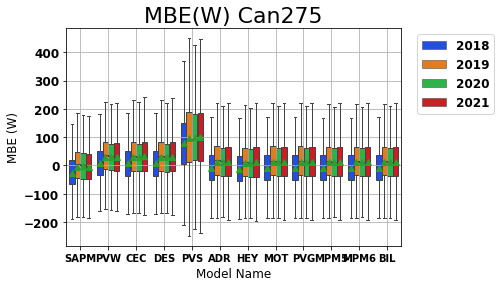

In [147]:
ax = sns.boxplot(x='Model Name', y='MBE (W)', data = meta, hue='Year', showmeans=True, showfliers=False,palette='bright')
ax.grid(True)
#ax.set_ylim([0,10])
ax.set_title('MBE(W) '+mod_name)
ax.legend(bbox_to_anchor= (1.03, 1))

# **Misc Plotting begins here and is saved for easy reference for syntax & formatting. In the near future I plan to make a notebook that has a wide variety of plots & styles to use instead of keeping them here.**

In [1]:
#THIS CELL IS FOR GENERATING A FILTERS DF TO MAKE VISUAL_DOTS GRAPHS
#sol_elev_mask = sol_elev_mask[~sol_elev_mask.index.duplicated(keep='first')]
#filters = pd.merge(eff_irr_mask, tcell_mask, how='inner', on='TmStamp')
#filters['ratio_mask'] = ratio_mask
#filters['sol_elev_mask'] = sol_elev_mask

In [2]:
##visual_dots(meta['Str_1'],filters['mask_eff_irr'] ,0,4500)

In [3]:
#visual_dots(meta['Str_1'],filters['mask_tcell'] ,0,4500)

In [4]:
#visual_dots(meta['Str_1'],filters['ratio_mask'] ,0,4500)

In [5]:
#visual_dots(meta['Str_1'],filters['sol_elev_mask'],0,4500)

In [49]:
#Calculate R2 value for every model
pd.options.mode.chained_assignment = None 
r2=[]
models = ['SAPM', 'PVW', 'CEC', 'DES','PVS', 'ADR', 'HEY', 'MOT', 'PVG', 'MPM5', 'MPM6', 'BIL']
for model in models:
    model_meta = meta.loc[meta['Model Name']==model]
    model_meta.dropna(inplace=True)
    model_r2 =  str(round((r2_score(y_true=model_meta['Str_1'], y_pred=model_meta['Modeled Power'])), 4))
    r2.append(model_r2)

Text(1500, 4000, 'R2 = 0.9883')

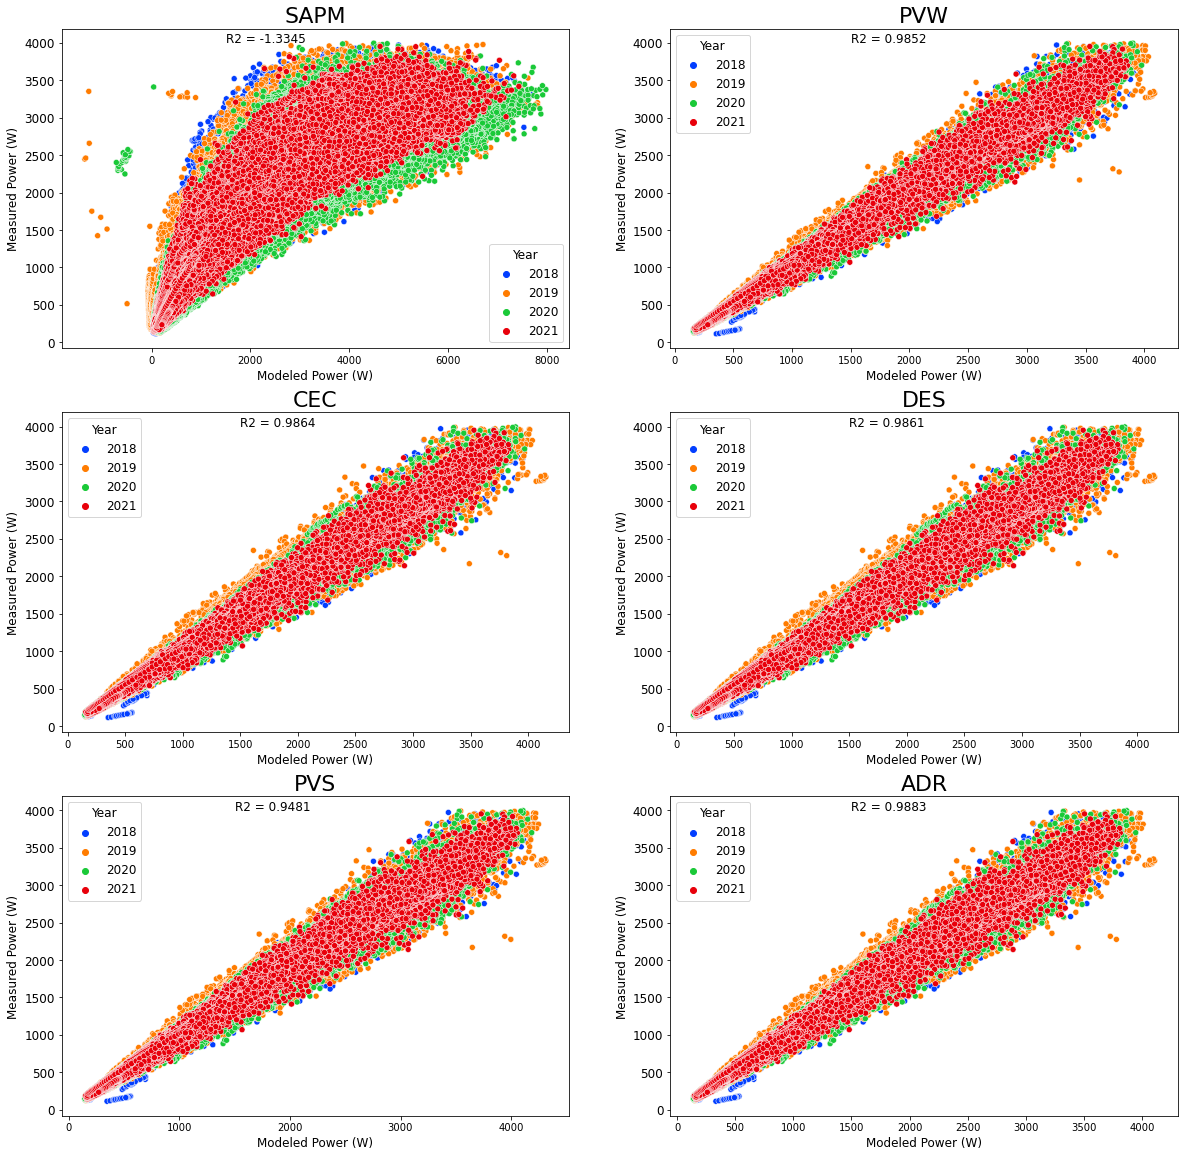

In [50]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
mod_meta = meta.loc[meta['Model Name']=='SAPM']
ax = sns.scatterplot(x=mod_meta['Modeled Power'], y=mod_meta['Str_1'], hue='Year',ax = axes[0,0], data=mod_meta, palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('SAPM')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[0]))
mod_meta = meta.loc[meta['Model Name']=='PVW']
ax = sns.scatterplot(x=mod_meta['Modeled Power'], y=mod_meta['Str_1'], hue='Year',ax = axes[0,1], data=mod_meta, palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('PVW')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[1]))
mod_meta = meta.loc[meta['Model Name']=='CEC']
ax = sns.scatterplot(x=mod_meta['Modeled Power'], y=mod_meta['Str_1'], hue='Year',ax = axes[1,0], data=mod_meta, palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('CEC')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[2]))
mod_meta = meta.loc[meta['Model Name']=='DES']
ax = sns.scatterplot(x=mod_meta['Modeled Power'], y=mod_meta['Str_1'], hue='Year',ax = axes[1,1], data=mod_meta, palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('DES')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[3]))
mod_meta = meta.loc[meta['Model Name']=='PVS']
ax = sns.scatterplot(x=mod_meta['Modeled Power'], y=mod_meta['Str_1'], hue='Year',ax = axes[2,0], data=mod_meta, palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('PVS')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[4]))
mod_meta = meta.loc[meta['Model Name']=='ADR']
ax = sns.scatterplot(x=mod_meta['Modeled Power'], y=mod_meta['Str_1'], hue='Year',ax = axes[2,1], data=mod_meta, palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('ADR')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[5]))

KeyboardInterrupt: 

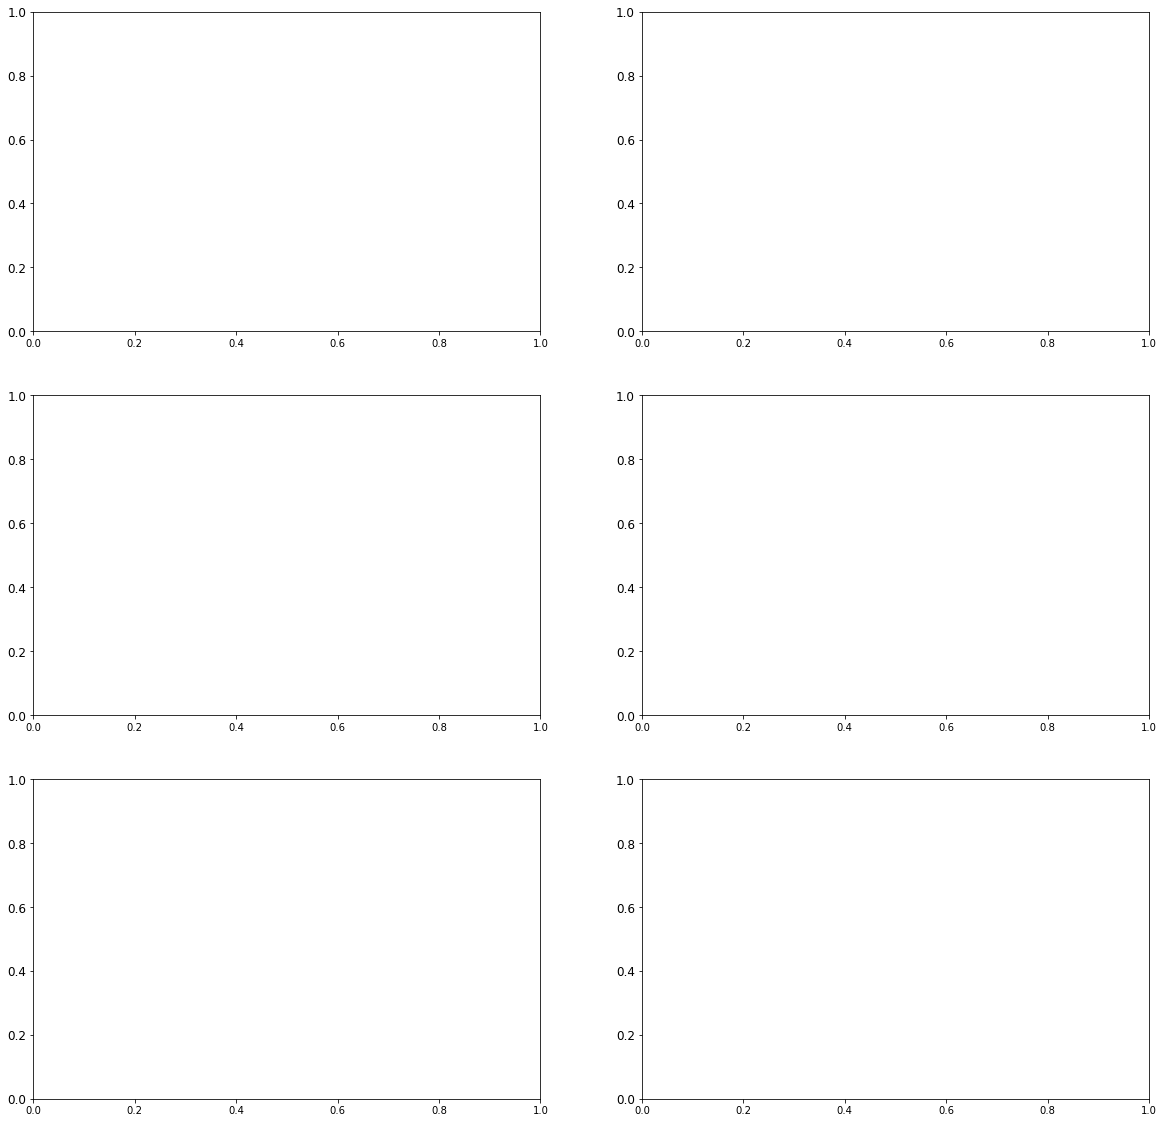

In [430]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
ax = sns.scatterplot(x=meta['Modeled Power'], y=meta['Str_1'], hue='Year',ax = axes[0,0], data=meta.loc[meta['Model Name']=='HEY'], palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('HEY')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[6]))
ax = sns.scatterplot(x=meta['Modeled Power'], y=meta['Str_2'], hue='Year',ax = axes[0,1], data=meta.loc[meta['Model Name']=='MOT'], palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('MOT')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[7]))
ax = sns.scatterplot(x=meta['Modeled Power'], y=meta['Str_3'], hue='Year',ax = axes[1,0], data=meta.loc[meta['Model Name']=='PVG'], palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('PVG')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[8]))
ax = sns.scatterplot(x=meta['Modeled Power'], y=meta['Str_4'], hue='Year',ax = axes[1,1], data=meta.loc[meta['Model Name']=='MPM5'], palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('MPM5')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[9]))
ax = sns.scatterplot(x=meta['Modeled Power'], y=meta['Str_1'], hue='Year',ax = axes[2,0], data=meta.loc[meta['Model Name']=='MPM6'], palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('MPM6')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[10]))
ax = sns.scatterplot(x=meta['Modeled Power'], y=meta['Str_1'], hue='Year',ax = axes[2,1], data=meta.loc[meta['Model Name']=='BIL'], palette='bright')
ax.set_xlabel('Modeled Power (W)')
ax.set_ylabel('Measured Power (W)')
ax.set_title('BIL')
ax.text(x=1500, y=4000, s=('R2 = ' + r2[11]))

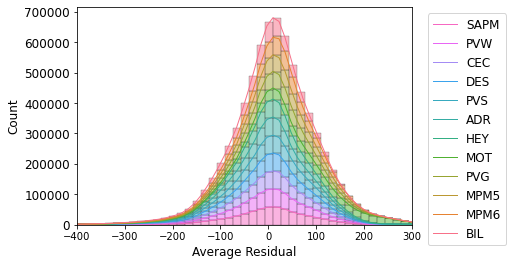

In [110]:
#Average Residuals
ax = sns.histplot(x= "MBE (W)", data=meta,bins=150,  hue="Model Name", kde=True, legend = True,multiple = "stack", fill = True)
ax.set_xlim([-400,300])
ax.set_xlabel('Average Residual')
ax.legend( ['SAPM', 'PVW', 'CEC', 'DES', 'PVS', 'ADR', 'HEY', 'MOT', 'PVG', 'MPM5', 'MPM6', 'BIL'], bbox_to_anchor=(1.03,1), loc='upper left')

In [108]:
meta_2020 = meta.loc[meta['Year']==2020]
resids = [meta_2020['Diff Str_1'],meta_2020['Diff Str_2'],meta_2020['Diff Str_3'],meta_2020['Diff Str_4']]
resids = pd.concat(resids, ignore_index=True)
models = [meta_2020['Model Name'],meta_2020['Model Name'],meta_2020['Model Name'],meta_2020['Model Name']]
models = pd.concat(models, ignore_index=True)
final = pd.concat([resids, models], axis=1)
final.rename(columns = {0 : 'Residual'}, inplace = True)

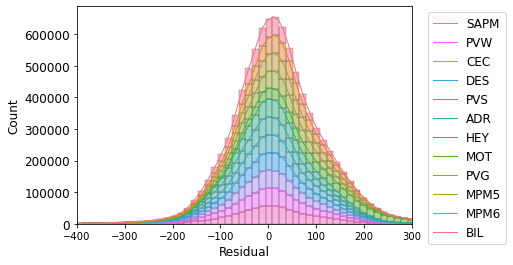

In [109]:
ax = sns.histplot(x= "Residual", data=final,bins=150,  hue="Model Name", kde=True, legend = True,multiple = "stack", fill = True)
ax.set_xlim([-400,300])
ax.set_xlabel('Residual')
ax.legend( ['SAPM', 'PVW', 'CEC', 'DES', 'PVS', 'ADR', 'HEY', 'MOT', 'PVG', 'MPM5', 'MPM6', 'BIL'], bbox_to_anchor=(1.03,1), loc='upper left')

In [397]:
#meta.index=meta['Time']
#meta.loc[meta['Year']==2019]['Diff Str_1'].sort_values(ascending=False).head(45)

Various plotting saved for formatting

In [ ]:
lg_meta = meta
pan_meta = meta
can275_meta = meta
frames = [lg_meta, pan_meta, can275_meta]
meta_results = pd.concat(frames, ignore_index=True)
meta_results = meta_results.loc[meta_results['Year'] == 2020]
meta_results.rename(columns = {'MAPE' : 'MAPE (%)'}, inplace = True)
ax = sns.boxplot(x = 'System', y = 'MAPE (%)', data = meta_results, showmeans=True, showfliers=False)
ax.grid(True)
#ax.set_ylim([0, 8])
ax.set_title('SAPM MAPE for PVLT Systems')
#ax.legend(bbox_to_anchor= (1.03, 1))

In [ ]:
mape = pd.read_csv('HanQPeak_meta.csv')
ax = sns.boxplot(x = 'Model Name', y = 'MAPE', data = mape,hue='Year', showmeans=True, palette='bright', showfliers=False)
ax.set_ylim([0,12.5])
ax.grid(True)
ax.legend(loc='upper right')
ax.set_title('Panasonic')

In [182]:
lg_results = meta_results.loc[meta_results['System']=='LG']
pan_results = meta_results.loc[meta_results['System']=='Panasonic']
can275_results = meta_results.loc[meta_results['System']=='Can275']
plt.scatter(dlg_results.index, dlg_results['Str_1'], s=10)
plt.scatter(dlg_results.index, dlg_results['Modeled Power'], s=10)
plt.xlabel(' Time')
plt.ylabel('Power (W)')
plt.title('Measured and SAPM Power for PVLT LG ')
plt.legend(bbox_to_anchor= (1.03, 1), labels=['Measured', 'SAPM'])

In [184]:
lg_results['Modeled Power'].plot()
lg_results['Str_1'].plot()
plt.xlim(datetime.datetime(2020,6, 7, 5), datetime.datetime(2020,6,9,5))
plt.legend( labels=['SAPM', 'Measured'])
plt.xlabel(' Time')
plt.ylabel('Power (W)')
plt.title('Measured and SAPM Power for PVLT LG')

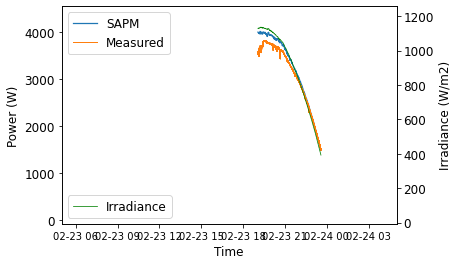

In [302]:
fig, ax = plt.subplots()
ax.plot(meta.loc[meta['Model Name']=='DES']['Modeled Power'], linewidth=1.25)
ax.plot(meta['Str_1'])
ax.set_xlabel('Time')
ax.set_ylabel('Power (W)')
ax.set_xlim(datetime.datetime(2019,2, 23,5), datetime.datetime(2019,2,24, 5))
ax2 = ax.twinx()
ax2.plot(df['eff_irr'], color='green', linewidth=0.75)
ax2.set_ylabel('Irradiance (W/m2)')
ax.legend(['SAPM', 'Measured'], loc='upper left')
ax2.legend(['Irradiance'], loc='lower left')
plt.show()

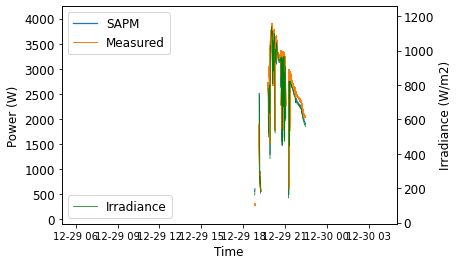

In [151]:
fig, ax = plt.subplots()
ax.plot(meta.loc[meta['Model Name']=='SAPM']['Modeled Power'], linewidth=1.25)
ax.plot(meta['Str_1'])
ax.set_xlabel('Time')
ax.set_ylabel('Power (W)')
ax.set_xlim(datetime.datetime(2019,12, 29,5), datetime.datetime(2019,12,30, 5))
ax2 = ax.twinx()
ax2.plot(df['eff_irr'], color='green', linewidth=0.75)
ax2.set_ylabel('Irradiance (W/m2)')
ax.legend(['SAPM', 'Measured'], loc='upper left')
ax2.legend(['Irradiance'], loc='lower left')
plt.show()